In [6]:
import pandas as pd
df_no_outliers = pd.read_csv("C:/Users/Zainab/Downloads/swimming_data_no_outliers.csv")

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Define features and target for race time prediction:
features = ['Ranking_numeric', 'Distance', 'Sex', 'Event']
target = 'Time_seconds'
X = df_no_outliers[features]
y = df_no_outliers[target]

# Define numeric and categorical features
numeric_features = ['Ranking_numeric', 'Distance']
categorical_features = ['Sex', 'Event']

# Create a preprocessing pipeline for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Build a pipeline that first preprocesses the data and then applies XGBoost Regressor
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, set up hyperparameter tuning via GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and performance on cross-validation
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("XGBoost Test RMSE:", rmse)
print("XGBoost Test R²:", r2)

# Get the XGBRegressor from the pipeline
xgb_model = best_model.named_steps['xgb']
importances = xgb_model.feature_importances_

# Get the transformed feature names from OneHotEncoder
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, ohe_features])
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
XGBoost Test RMSE: 4.455151105216581
XGBoost Test R²: 0.9996281550444266

Feature Importances:
                            Feature  Importance
1                          Distance    0.960409
14  Event_4 x 100 m freestyle relay    0.013506
16  Event_4 x 200 m freestyle relay    0.009607
0                   Ranking_numeric    0.003364
15     Event_4 x 100 m medley relay    0.003025
2                        Sex_Female    0.002552
10         Event_200 m breaststroke    0.001867
18    Event_400 m individual medley    0.001718
17            Event_400 m freestyle    0.001598
12            Event_200 m freestyle    0.000924
5          Event_100 m breaststroke    0.000573
11            Event_200 m butterfly    0.000258
9            Event_200 m backstroke    0.000223
22             Event_50 m freestyle    0.000102
23            Event_800 m freestyle    0.000083
13    Event_200 m indi

In [3]:
pip install shap


     -------------------------------------- 530.6/530.6 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


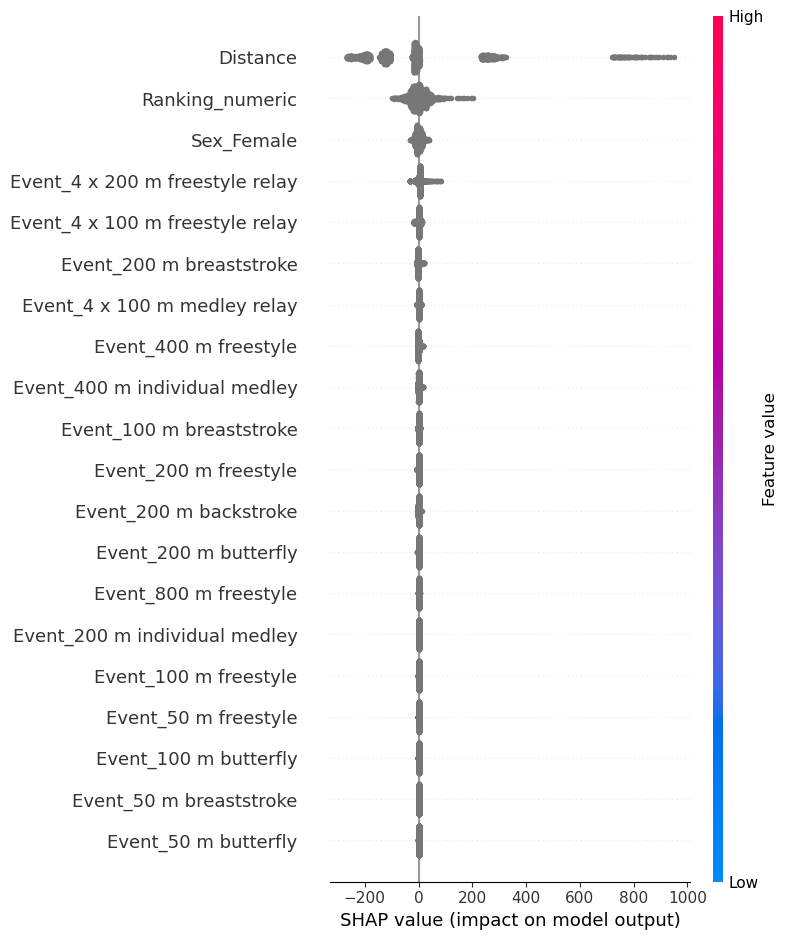

In [8]:
import shap
import numpy as np


best_model = grid_search.best_estimator_

# Extract the XGBoost model from the pipeline 
xgb_model = best_model.named_steps['xgb']

# Extract the preprocessor from the pipeline
preprocessor = best_model.named_steps['preprocessor']

# Transform the training data using the preprocessor
X_train_transformed = preprocessor.transform(X_train)

# Get feature names numeric ones are the same categorical features come from OneHotEncoder
numeric_features = ['Ranking_numeric', 'Distance']
categorical_features = ['Sex', 'Event']
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

# Create a SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values on the transformed training data
shap_values = explainer.shap_values(X_train_transformed)

# Plot the SHAP summary plot to visualize feature impact
shap.summary_plot(shap_values, X_train_transformed, feature_names=all_feature_names)


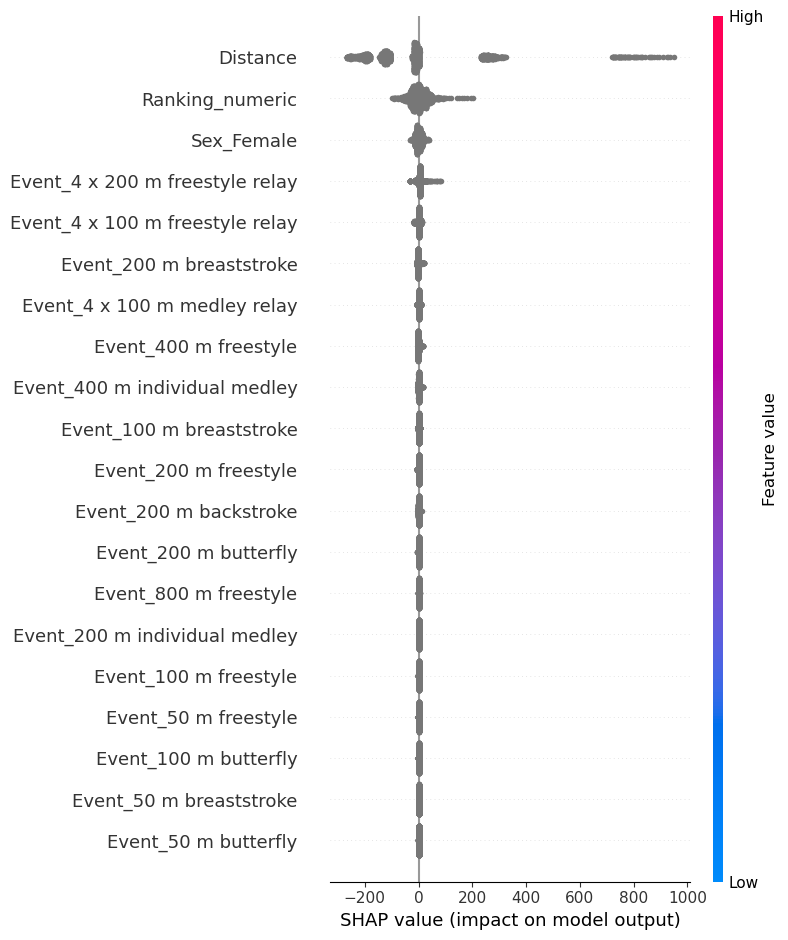

In [9]:
# Create a SHAP TreeExplainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the training set (transformed)
shap_values = explainer.shap_values(X_train_transformed)

# Plot the summary plot to see feature importance and effects
shap.summary_plot(shap_values, X_train_transformed, feature_names=all_feature_names)


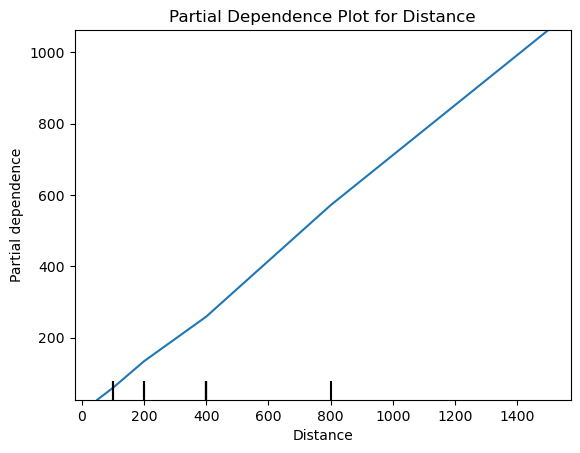

In [10]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt


features_for_pd = ['Distance']  

# Create a partial dependence plot for Distance using the best_model pipeline
PartialDependenceDisplay.from_estimator(best_model, X_train, features_for_pd, kind='average', grid_resolution=50)
plt.title("Partial Dependence Plot for Distance")
plt.show()


In [12]:
import os



df_no_outliers['XGB_Predicted_Time'] = best_model.predict(df_no_outliers[features])

)
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "xgb_predictions.csv")


df_no_outliers.to_csv(downloads_path, index=False)
print("XGBoost predictions saved to:", downloads_path)


XGBoost model saved to: C:\Users\Zainab\Downloads\xgboost_model.pkl
